Missing values in the dataset:
ID#                  0
Balance              0
Qual_miles           0
cc1_miles            0
cc2_miles            0
cc3_miles            0
Bonus_miles          0
Bonus_trans          0
Flight_miles_12mo    0
Flight_trans_12      0
Days_since_enroll    0
Award?               0
dtype: int64

Applying K-Means Clustering...


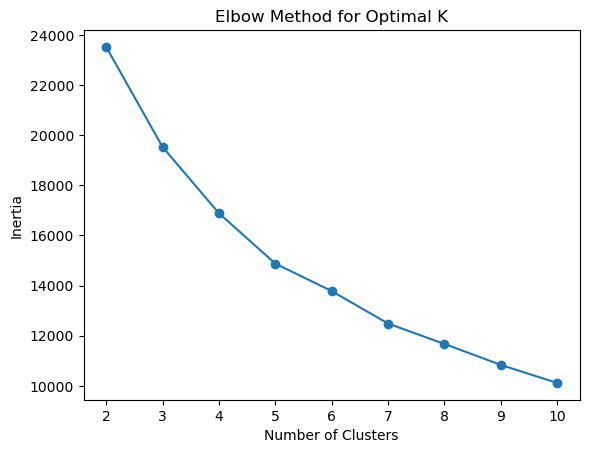

Silhouette Score for K-Means: 0.30

Applying Hierarchical Clustering...


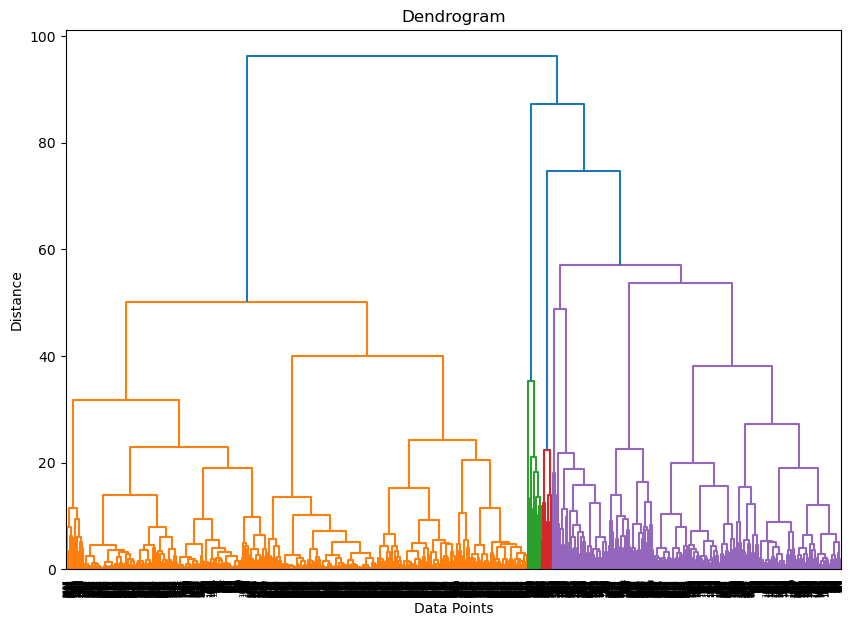

Silhouette Score for Hierarchical Clustering: 0.25

Applying DBSCAN Clustering...
DBSCAN: eps=0.5, min_samples=3, Silhouette=-0.14
DBSCAN: eps=0.5, min_samples=5, Silhouette=-0.06
DBSCAN: eps=0.5, min_samples=10, Silhouette=0.01
DBSCAN: eps=1.0, min_samples=3, Silhouette=0.09
DBSCAN: eps=1.0, min_samples=5, Silhouette=0.08
DBSCAN: eps=1.0, min_samples=10, Silhouette=0.09
DBSCAN: eps=1.5, min_samples=3, Silhouette=0.58
DBSCAN: eps=1.5, min_samples=5, Silhouette=0.59
DBSCAN: eps=1.5, min_samples=10, Silhouette=0.58
DBSCAN: eps=2.0, min_samples=3, Silhouette=0.67
DBSCAN: eps=2.0, min_samples=5, Silhouette=0.60
DBSCAN: eps=2.0, min_samples=10, Silhouette=0.65
DBSCAN found 2 clusters and 253 noise points.
Silhouette Score for DBSCAN: 0.59

Visualizing Clustering Results...


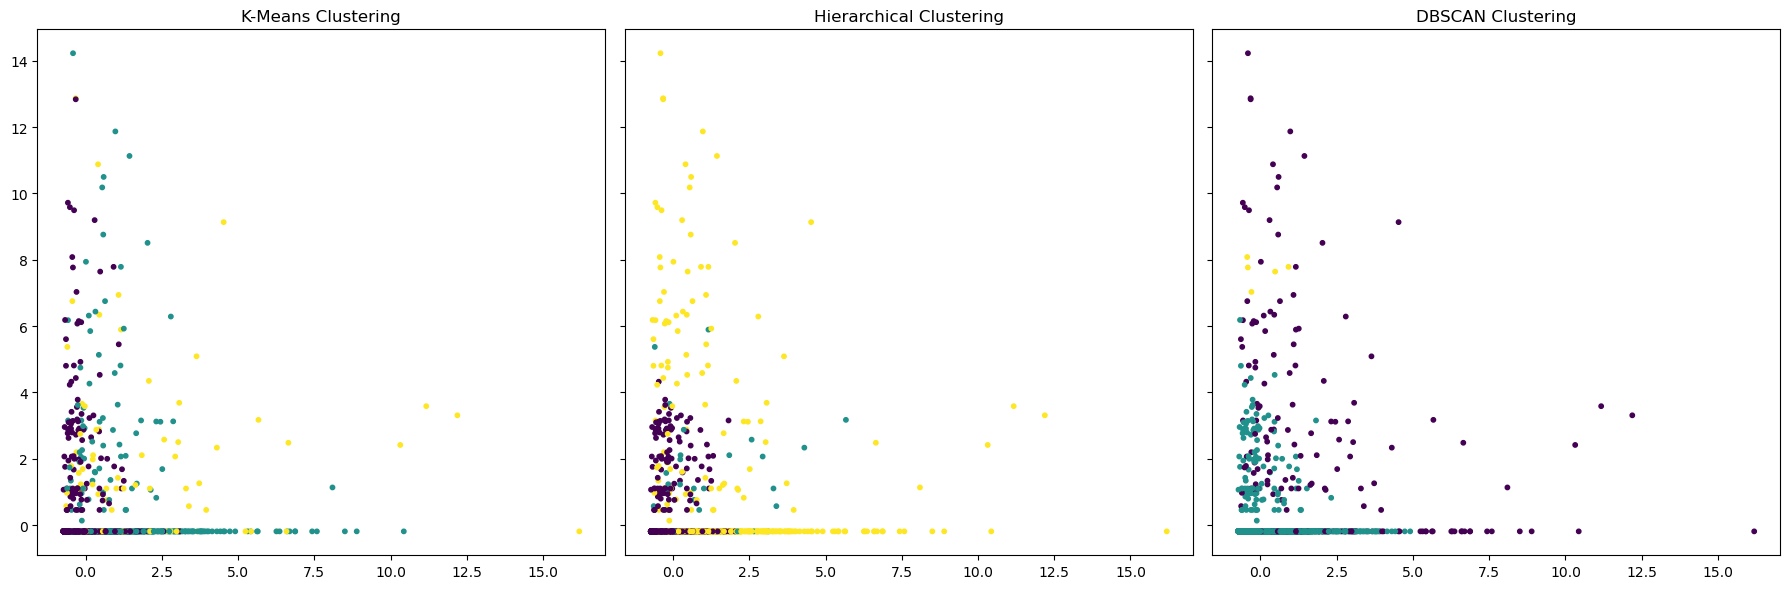

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans, DBSCAN
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.metrics import silhouette_score

# Load the dataset
file_path = r'C:\Users\User\Downloads\Clustering\Clustering\EastWestAirlines.xlsx'

data = pd.ExcelFile(file_path)

# Parse the "data" sheet
data_sheet = data.parse('data')

# 1. Check for missing values
print("Missing values in the dataset:")
print(data_sheet.isnull().sum())

# 2. Remove ID column (not relevant for clustering)
data_cleaned = data_sheet.drop(['ID#'], axis=1)

# 3. Handle missing values (if any) - fill with median
if data_cleaned.isnull().values.any():
    data_cleaned.fillna(data_cleaned.median(), inplace=True)

# 4. Separate categorical and numerical features
categorical_features = ['cc1_miles', 'cc2_miles', 'cc3_miles']
numerical_features = [col for col in data_cleaned.columns if col not in categorical_features + ['Award?']]

# Define preprocessing steps
numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(drop='first')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Apply preprocessing
data_preprocessed = preprocessor.fit_transform(data_cleaned)

# Convert back to DataFrame for easier handling
encoded_categorical_columns = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
columns_transformed = numerical_features + list(encoded_categorical_columns)
data_preprocessed_df = pd.DataFrame(data_preprocessed, columns=columns_transformed)

# 5. K-Means Clustering
print("\nApplying K-Means Clustering...")
inertia = []
k_values = range(2, 11)
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data_preprocessed)
    inertia.append(kmeans.inertia_)

# Elbow Method
plt.figure()
plt.plot(k_values, inertia, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

# Fit K-Means with optimal K (e.g., K=3)
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans_labels = kmeans.fit_predict(data_preprocessed)
print(f"Silhouette Score for K-Means: {silhouette_score(data_preprocessed, kmeans_labels):.2f}")

# 6. Hierarchical Clustering
print("\nApplying Hierarchical Clustering...")
linkage_matrix = linkage(data_preprocessed, method='ward')

# Dendrogram
plt.figure(figsize=(10, 7))
dendrogram(linkage_matrix)
plt.title('Dendrogram')
plt.xlabel('Data Points')
plt.ylabel('Distance')
plt.show()

# Fit hierarchical clustering (e.g., 3 clusters)
hierarchical_labels = fcluster(linkage_matrix, t=3, criterion='maxclust')
print(f"Silhouette Score for Hierarchical Clustering: {silhouette_score(data_preprocessed, hierarchical_labels):.2f}")

# 7. DBSCAN Clustering
print("\nApplying DBSCAN Clustering...")
# Optimize DBSCAN parameters
best_eps = 1.5
best_min_samples = 5
for eps in [0.5, 1.0, 1.5, 2.0]:
    for min_samples in [3, 5, 10]:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        dbscan_labels = dbscan.fit_predict(data_preprocessed)
        if len(set(dbscan_labels)) > 1:
            silhouette = silhouette_score(data_preprocessed, dbscan_labels)
            print(f"DBSCAN: eps={eps}, min_samples={min_samples}, Silhouette={silhouette:.2f}")

# Final DBSCAN Model
dbscan = DBSCAN(eps=1.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(data_preprocessed)

# Evaluate DBSCAN
unique_labels = set(dbscan_labels)
print(f"DBSCAN found {len(unique_labels) - (1 if -1 in unique_labels else 0)} clusters and {list(dbscan_labels).count(-1)} noise points.")
if len(unique_labels) > 1:
    print(f"Silhouette Score for DBSCAN: {silhouette_score(data_preprocessed, dbscan_labels):.2f}")
else:
    print("Silhouette Score for DBSCAN cannot be calculated due to a single cluster.")

# 8. Visualize Clustering Results
print("\nVisualizing Clustering Results...")
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# K-Means Visualization
axes[0].scatter(data_preprocessed[:, 0], data_preprocessed[:, 1], c=kmeans_labels, cmap='viridis', s=10)
axes[0].set_title('K-Means Clustering')

# Hierarchical Clustering Visualization
axes[1].scatter(data_preprocessed[:, 0], data_preprocessed[:, 1], c=hierarchical_labels, cmap='viridis', s=10)
axes[1].set_title('Hierarchical Clustering')

# DBSCAN Visualization
axes[2].scatter(data_preprocessed[:, 0], data_preprocessed[:, 1], c=dbscan_labels, cmap='viridis', s=10)
axes[2].set_title('DBSCAN Clustering')

plt.tight_layout()
plt.show()
